# Calculate TSS enrichment score

This notebook is included to document and work around a subtle but important detail in how Signac computes TSS enrichment. By default, Signac’s TSS enrichment metric differs from the more conventional definition used by tools like ArchR and by ENCODE: it uses a smaller window size around the TSS and treats the central half of that window as the “peak” region when computing the peak-to-background ratio. As a result, Signac typically reports substantially lower TSS enrichment values than ArchR or ENCODE-style calculations, even on the same data. This behavior is not a bug, but directly reporting the raw Signac values can be misleading if readers assume they are comparable to the standard ENCODE metric. This discrepancy is discussed in more detail in the Signac issue tracker (see https://github.com/stuart-lab/signac/issues/1638
). In this notebook, I provide a simple modification of the internal Signac TSS enrichment function to more closely match the conventional definition, so that the resulting values are easier to interpret and compare across tools. 

**Although this adjusted metric will still not be numerically identical to the values reported by ArchR or ENCODE, all TSS enrichment scores in the CHARM manuscript are computed using this method, so the results across different analysis workflows are directly comparable within that framework.**

In [1]:
library(Seurat)
library(tidyverse)
library(Signac)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: 'SeuratObject'


The following object is masked from 'package:base':

    intersect


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
charm = readRDS("/zliu_ssd/CHARM/CHARM_brain/1_createobj_embedding/charm_subset.rds")

In [3]:
my_TSSEnrichment <- function(
  object,
  tss.positions = NULL,
  assay = NULL,
  n=NULL,
  cells = NULL,
  process_n = 2000,
  verbose = TRUE,
  region_extension = 2000
) {
  print("Using modified TSSEnrichment function")
  assay <- SetIfNull(x = assay, y = DefaultAssay(object = object))
  if (!inherits(x = object[[assay]], what = "ChromatinAssay")) {
    stop("The requested assay is not a ChromatinAssay")
  }
  # first check that fragments are present
  frags <- Fragments(object = object[[assay]])
  if (length(x = frags) == 0) {
    stop("No fragment files present in assay")
  }
  if (is.null(x = tss.positions)) {
    if (verbose) {
      message("Extracting TSS positions")
    }
    # work out TSS positions from gene annotations
    annotations <- Annotation(object = object[[assay]])
    if (is.null(x = annotations)) {
      stop("No gene annotations present in assay")
    }
    tss.positions <- GetTSSPositions(ranges = annotations)
  }
  if (!is.null(x = n)) {
    if (n > length(x = tss.positions)) {
      n <- length(x = tss.positions)
    }
    tss.positions <- tss.positions[1:n, ]
  }
  
  # exclude chrM
  sn <- seqnames(x = tss.positions)
  tss.positions <- tss.positions[!as.character(sn) %in% c("chrM", "Mt", "MT")]
  
  tss.positions <- Extend(
    x = tss.positions,
    upstream = region_extension,
    downstream = region_extension,
    from.midpoint = TRUE
  )
  cutmatrix <- CreateRegionPileupMatrix(
    object = object,
    regions = tss.positions,
    assay = assay,
    cells = cells,
    verbose = verbose
  )
  
  if (verbose) {
    message("Computing mean insertion frequency in flanking regions")
  }
  total_region_length <- (2 * region_extension) + 1
  right_flank <- seq.int(from = (total_region_length - 99), to = total_region_length)
  flanking.mean <- rowMeans(x = cutmatrix[, c(1:100, right_flank)])
  
  # if the flanking mean is 0 for any cells, the enrichment score will be zero.
  # instead replace with the mean from the whole population
  flanking.mean[is.na(x = flanking.mean)] <- 0
  flanking.mean[flanking.mean == 0] <- mean(flanking.mean, na.rm = TRUE)
  
  # compute fold change at each position relative to flanking mean
  # (flanks should start at 1)
  if (verbose) {
    message("Normalizing TSS score")
  }
  
  norm.matrix <- cutmatrix / flanking.mean
  
  # Take the maximum average signal across any consecutive 100 bp window after normalization
  window_size <- 100
  max_window_mean <- function(row_values, window) {
    numeric_values <- as.numeric(row_values)
    total_length <- length(numeric_values)
    if (total_length < window) {
      if (all(is.na(numeric_values))) {
        return(NA_real_)
      }
      return(mean(numeric_values, na.rm = TRUE))
    }
    valid_flags <- !is.na(numeric_values)
    replaced_values <- numeric_values
    replaced_values[!valid_flags] <- 0
    value_cumsum <- c(0, cumsum(replaced_values))
    count_cumsum <- c(0, cumsum(as.integer(valid_flags)))
    window_sums <- value_cumsum[(window + 1):(total_length + 1)] - value_cumsum[1:(total_length - window + 1)]
    window_counts <- count_cumsum[(window + 1):(total_length + 1)] - count_cumsum[1:(total_length - window + 1)]
    window_means <- ifelse(window_counts > 0, window_sums / window_counts, NA_real_)
    if (all(is.na(window_means))) {
      return(NA_real_)
    }
    max(window_means, na.rm = TRUE)
  }
  cell_names <- rownames(norm.matrix)
  object$TSS.enrichment <- vapply(
    X = seq_len(nrow(norm.matrix)),
    FUN = function(idx) max_window_mean(norm.matrix[idx, ], window = window_size),
    FUN.VALUE = numeric(1)
  )
  if (!is.null(cell_names)) {
    names(object$TSS.enrichment) <- cell_names
  }
  e.dist <- ecdf(x = object$TSS.enrichment)
  object$TSS.percentile <- round(
    x = e.dist(object$TSS.enrichment),
    digits = 2
  )
  
  # store expected as one additional row in the matrix
  expected.insertions <- rep(1, ncol(x = cutmatrix))
  expected.insertions <- t(x = as.matrix(x = expected.insertions))
  rownames(x = expected.insertions) <- "expected"
  
  # encode motif position as additional row in matrix
  motif.vec <- t(x = matrix(
    data = c(
      rep(x = 0, region_extension),
      1,
      rep(x = 0, region_extension)
    )
  )
  )
  rownames(x = motif.vec) <- "motif"
  
  # append
  norm.matrix <- rbind(norm.matrix, expected.insertions)
  norm.matrix <- rbind(norm.matrix, motif.vec)
  
  # store the normalized TSS matrix
  object <- SetAssayData(
    object = object,
    assay = assay,
    layer = "positionEnrichment",
    new.data = norm.matrix,
    key = "TSS"
  )
  return(object)
}


environment(my_TSSEnrichment) <- asNamespace("Signac")
trace("TSSEnrichment",
  tracer = quote({
    args <- as.list(match.call(expand.dots = TRUE))[-1]
    return(do.call(my_TSSEnrichment, args))
  }),
  print = FALSE,
  where = asNamespace("Signac")
)


Tracing function "TSSEnrichment" in package "namespace:Signac"



[1] "TSSEnrichment"

In [4]:
DefaultAssay(charm) <- 'atac'

In [5]:
tss_df = read_tsv("/shared/zliu/4_cregene/metacell_brain/tss.bed", col_names = c("chrom", "start", "end", "gene","strand"))
# convert to GRanges
tss_gr <- GenomicRanges::makeGRangesFromDataFrame(tss_df, keep.extra.columns = TRUE,
                                  seqnames.field = "chrom",
                                  start.field = "start",
                                  end.field = "end")

Rows: 21251 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): chrom, gene, strand
dbl (2): start, end

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
charm = my_TSSEnrichment(charm,tss.positions = tss_gr,assay = "atac")

[1] "Using modified TSSEnrichment function"


Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score

Warning message:
"The following arguments are not used: key"


In [7]:
library(RColorBrewer)
get_optimized_colors <- function(palette, n) {
  colorRampPalette(brewer.pal(9, palette))(max(n, 9))[seq_len(n)] # 确保最小取色数
}
excitatory_colors <- get_optimized_colors("Reds", 12)[3:12]  
inhibitory_colors <- get_optimized_colors("Blues", 11)[3:12] 
glia_colors <- get_optimized_colors("Greens", 7)[3:6]     


celltype_colors <- c(
  "Ex_Unknown1" = excitatory_colors[1], 
  "Ex_Unknown2" = excitatory_colors[2],
  "Ex_OB" = excitatory_colors[3],
  "Ex_L2/3_IT" = excitatory_colors[4],
  "Ex_L3/4_IT" = excitatory_colors[5],
  "Ex_L5/6_IT" = excitatory_colors[6],
  "Ex_L5/6_NP" = excitatory_colors[7],
  "Ex_L6_CT" = excitatory_colors[8],   
  "Ex_CL" = excitatory_colors[9],
  
  # 抑制性神经元（7类）
  "Inh_Unknown1" = inhibitory_colors[1],
  "Inh_Unknown2" = inhibitory_colors[2],
  "Inh_Pvalb" = inhibitory_colors[3],
  "Inh_Sst" = inhibitory_colors[4],  
  "Inh_MSN" = inhibitory_colors[5], 
  "Inh_Vip" = inhibitory_colors[6],
  "Inh_Ndnf/Lamp5" = inhibitory_colors[7],
  
  # 胶质细胞（4类）
  "Ast" = glia_colors[1],
  "OPC" = glia_colors[2],
  "ODC" = glia_colors[3],
  "Microglia" = glia_colors[4]
)

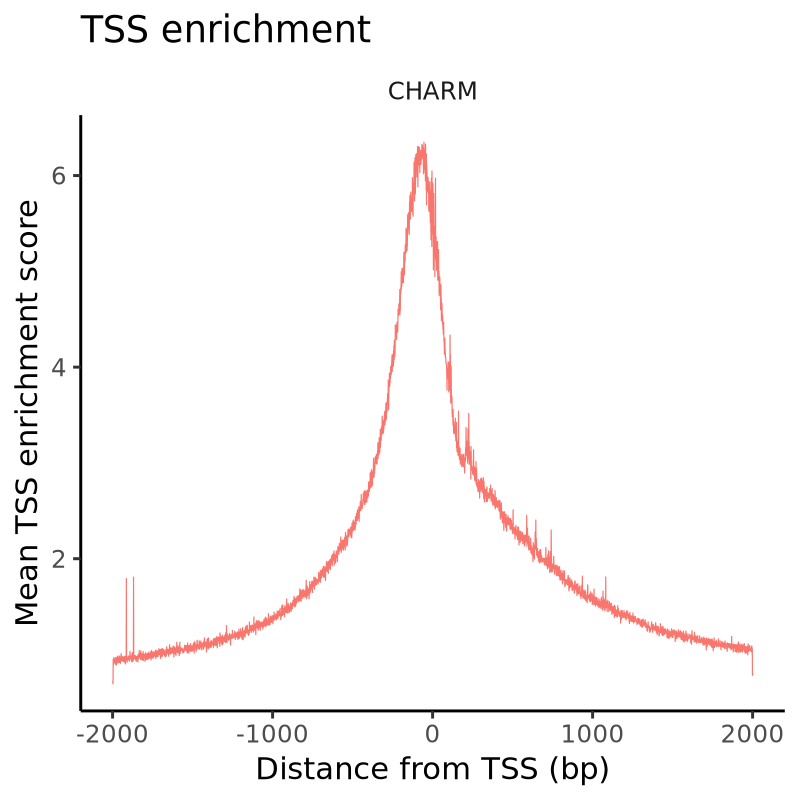

In [8]:
options(repr.plot.width=4, repr.plot.height=4,repr.plot.res=200)
TSSPlot(charm,group.by = "orig.ident")

In [9]:
charm[[]] %>% pull(	TSS.enrichment	) %>% median()

[1] 5.812144

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


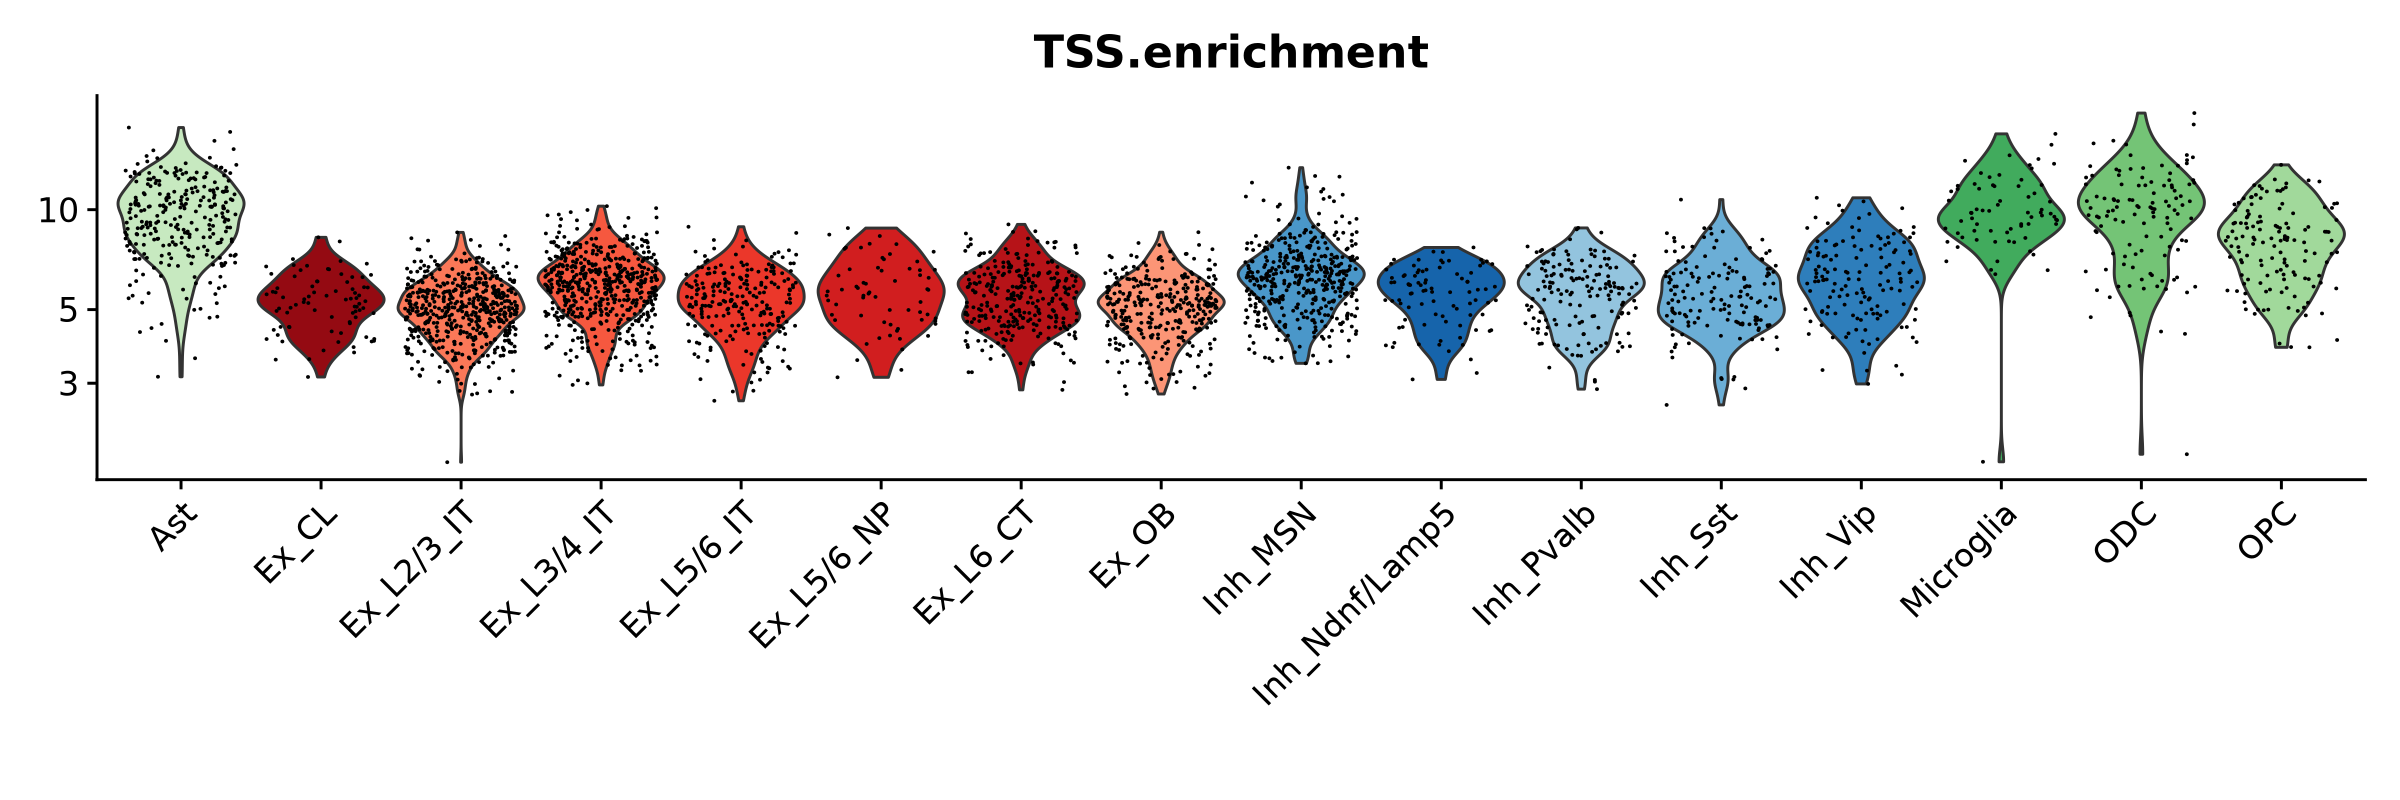

In [11]:
options(repr.plot.width=12, repr.plot.height=4,repr.plot.res=200)
VlnPlot(charm,features = c("TSS.enrichment"),group.by="celltype",cols=celltype_colors) + NoLegend()+xlab("") + scale_y_log10()